# Statistical Methods for High Dimensional Biology (STAT/BIOF/GSAT 540)


# <font color=red> Lecture 5: Two-group Comparisons and Statistical Inference

# Overview
Thoughtout the course we will work with a dataset obtained from GSE to understand the role of Nrl (neural retina leucine) gene in photoreceptor differntiation in mammals (see details [**Data description**](#Data-description)). In this lecture, we introduce classical statistical inference to compare gene expressions of wild-type *vs* Nrl-knockout models in mice.    

### Table of Contents:

1. [**Data description**](#Data-description)
    1. [Loading the data](#Loading-the-data)
    2. [Subsetting the data](#Subsetting-the-data)
2. [**Data visualization for two group comparisons**](#Data-visualization-for-two-group-comparisons)
    1. [Strip plots](#Strip-plots)
    2. [Density plots](#Density-and-violin-plots)
    3. [Boxplots](#Boxplots)
3. [**Statistical inference**](#Statistical-Inference)
    1. [t-test](#The-t-test)
    2. [The null distribution](#The-null-distribution)
    3. [Wilcoxon rank sum test](#Wilcoxon-Rank-Sum-Test)
    4. [Kolmogorov-Smirnov test](#Kolmogorov-Smirnov-Test-(two-sample))

### R Dependencies:

Please install the following packages on your local R console in order to run this Jupyter notebook.
- knitr
- dplyr
- ggplot2
- ggthemes
- grid
- gridExtra

In [1]:
library(knitr)
knitr::opts_knit$set(root.dir=".")

library(dplyr)

library(ggplot2)
library(ggthemes)

library(grid)
library(gridExtra)

Warning message:
“package ‘knitr’ was built under R version 3.5.2”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
“package ‘ggplot2’ was built under R version 3.5.2”Warning message:
“package ‘ggthemes’ was built under R version 3.5.2”
Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



# Data description

Dataset was obtained from: [GSE4051](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE4051)

> ## Targeting of GFP to new-born rods by Nrl promoter and temporal expression profiling of flow-sorted photoreceptors
Akimoto M, Cheng H, Zhu D, Brzezinski JA, Khanna R, Filippova E, Oh EC, Jing Y, Linares JL, Brooks M, Zareparsi S, Mears AJ, Hero A, Glaser T, Swaroop A.
<br><br>
The Maf-family transcription factor Nrl is a key regulator of photoreceptor differentiation in mammals. Ablation of the Nrl gene in mice leads to functional cones at the expense of rods. We show that a 2.5-kb Nrl promoter segment directs the expression of enhanced GFP specifically to rod photoreceptors and the pineal gland of transgenic mice. GFP is detected shortly after terminal cell division, corresponding to the timing of rod genesis revealed by birthdating studies. In Nrl-/- retinas, the GFP+ photoreceptors express S-opsin, consistent with the transformation of rod precursors into cones. We report the gene profiles of freshly isolated flow-sorted GFP+ photoreceptors from wild-type and Nrl-/- retinas at five distinct developmental stages. Our results provide a framework for establishing gene regulatory networks that lead to mature functional photoreceptors from postmitotic precursors. Differentially expressed rod and cone genes are excellent candidates for retinopathies.

### Overall Design
> Postmitotic rod precursors and mature rod photoreceptors are tagged by GFP under the control of an Nrl promoter in the wild type background (Wt-Gfp mice). When cross-bred into the Nrl-knockout background (Nrl-ko-Gfp mice), the transformed “S-cones” are tagged by GFP. GFP positive photoreceptors from the Wt-Gfp or Nrl-ko-Gfp retina were enriched (purified) by FACS at five distinct developmental stages (E16, P2, P6, P10, and 4 weeks). Total RNA was extracted by Trizol regent and around 50 ng of total RNA was used for linear amplification and biotin labeling following Nugene kit protocol. Fragmented cDNA was hybridized on Affymetrix mouse genomic expression array 430 2.0 and then scanned with the standard protocol. Four replicates were performed for each time point.

# Loading the data

In [2]:
#The design
prDes <- readRDS("data/GSE4051_design.rds")
str(prDes)

#The expression data
prDat<-read.table("data/GSE4051_data.tsv",
                  sep = "\t", header = T, row.names = 1)
str(prDat, list.len = 10)

'data.frame':	39 obs. of  4 variables:
 $ sidChar : chr  "Sample_20" "Sample_21" "Sample_22" "Sample_23" ...
 $ sidNum  : num  20 21 22 23 16 17 6 24 25 26 ...
 $ devStage: Factor w/ 5 levels "E16","P2","P6",..: 1 1 1 1 1 1 1 2 2 2 ...
 $ gType   : Factor w/ 2 levels "wt","NrlKO": 1 1 1 1 2 2 2 1 1 1 ...
'data.frame':	29949 obs. of  39 variables:
 $ Sample_20: num  7.24 9.48 10.01 8.36 8.59 ...
 $ Sample_21: num  7.41 10.02 10.04 8.37 8.62 ...
 $ Sample_22: num  7.17 9.85 9.91 8.4 8.52 ...
 $ Sample_23: num  7.07 10.13 9.91 8.49 8.64 ...
 $ Sample_16: num  7.38 7.64 8.42 8.36 8.51 ...
 $ Sample_17: num  7.34 10.03 10.24 8.37 8.89 ...
 $ Sample_6 : num  7.24 9.71 10.17 8.84 8.54 ...
 $ Sample_24: num  7.11 9.75 9.39 8.37 8.36 ...
 $ Sample_25: num  7.19 9.16 10.11 8.2 8.5 ...
 $ Sample_26: num  7.18 9.49 9.41 8.73 8.39 ...
  [list output truncated]


Here we examine the design of the study with a frequency table. We have four samples for each combination of development stage and genotype (except for "E16 and NrlKO", which has 3 samples)

In [3]:
with(prDes, table(devStage, gType))

         gType
devStage  wt NrlKO
  E16      4     3
  P2       4     4
  P6       4     4
  P10      4     4
  4_weeks  4     4

In [4]:
# Caculate total sample size of WT
wtSample <- with(prDes, sum(gType == "wt"))
paste("WT samples =", wtSample)

# Caculate total sample size of NrlKO
nrlkoSample <- with(prDes, sum(gType == "NrlKO"))
paste("NrlKO samples =", nrlkoSample)

[1] "WT samples = 20"

[1] "NrlKO samples = 19"

In the prDat dataframe, each row contains the expression data for each probeset and each column has all probesets expression data for each sample: a 29949 $\times$ 39 dataframe. 

In [5]:
dim(prDat)

[1] 29949    39

Let's take a peek at the expression data of the first 3 probesets and 5 samples in the dataframe.

In [6]:
head(subset(prDat, select = 1:5),3)

,Sample_20,Sample_21,Sample_22,Sample_23,Sample_16
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1415670_at,7.236,7.414,7.169,7.070,7.383
1415671_at,9.478,10.020,9.854,10.130,7.637
1415672_at,10.010,10.040,9.913,9.907,8.423


## Subsetting the data

Nrl is the gene that was knocked out in half the mice so we expect it to be differentially expressed. We will examine this hypothesis using statistical inference. For comparison, Nrl’s probeset ID is “1450946_at”. Irs4 (insulin receptor substrate 4) is selected as a "boring" non-differentially expressed gene. Irs4’s probeset ID is “1422248_at”.

We extract the rows for each of these genes, transpose and then vectorize the data. We then merge this data together with the design metadata. Ensure that the samples match between the data and design before merging.

In [7]:
miniDat <- as.vector(t(prDat[c("1422248_at", "1450946_at"), ]))
miniDat <- data.frame(gene = rep(c("Irs4", "Nrl"), each = nrow(prDes)),
                      gExp = miniDat)
miniDat <- data.frame(prDes, miniDat) # ignore the warning about row names
str(miniDat)
head(miniDat)
irsDat <- miniDat  %>% filter(gene == "IRs4") #DAVID: this doesn't work

Warning message in data.frame(prDes, miniDat):
“row names were found from a short variable and have been discarded”

'data.frame':	78 obs. of  6 variables:
 $ sidChar : chr  "Sample_20" "Sample_21" "Sample_22" "Sample_23" ...
 $ sidNum  : num  20 21 22 23 16 17 6 24 25 26 ...
 $ devStage: Factor w/ 5 levels "E16","P2","P6",..: 1 1 1 1 1 1 1 2 2 2 ...
 $ gType   : Factor w/ 2 levels "wt","NrlKO": 1 1 1 1 2 2 2 1 1 1 ...
 $ gene    : Factor w/ 2 levels "Irs4","Nrl": 1 1 1 1 1 1 1 1 1 1 ...
 $ gExp    : num  7.87 7.78 7.58 7.4 8.08 ...


sidChar,sidNum,devStage,gType,gene,gExp
<chr>,<dbl>,<fct>,<fct>,<fct>,<dbl>
Sample_20,20,E16,wt,Irs4,7.867
Sample_21,21,E16,wt,Irs4,7.783
Sample_22,22,E16,wt,Irs4,7.585
Sample_23,23,E16,wt,Irs4,7.400
Sample_16,16,E16,NrlKO,Irs4,8.076
Sample_17,17,E16,NrlKO,Irs4,7.515


Warning message in filter_impl(.data, quo):
“'.Random.seed[1]' is not a valid integer, so ignored”

# Data visualization for two-group comparisons 

We have a few options to visualize the differences in gene expression between genotypes in our dataset. In each plot, we generate a panel for each gene.

## Strip plots

We first examine the data using strip plots. Using `ggplot` we can plot both genes in 2 panels with matching x-axis scales to ease the comparison of their gene expression values. It is also possible to plot the average gene expression for each gene and genotype.

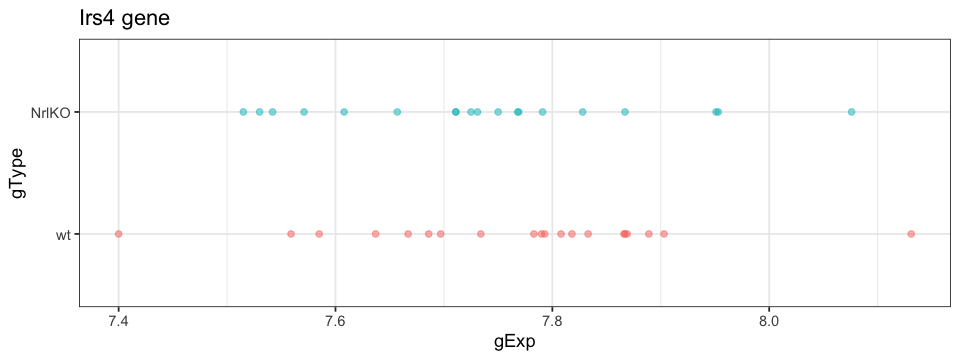

In [8]:
# Filter data for gene
irsDat <- filter(miniDat, gene == "Irs4") #DAVID: I get an error here, not sure why...

# Create and display plot of gene expression
options(repr.plot.width=8, repr.plot.height=3)

(irsLim <- ggplot(irsDat, aes(y = gExp, x = gType, colour = gType)) + 
             geom_point(alpha = 0.5) +
             labs(title = "Irs4 gene") +
             theme_bw() +
             theme(legend.position = "none") +
             coord_flip())

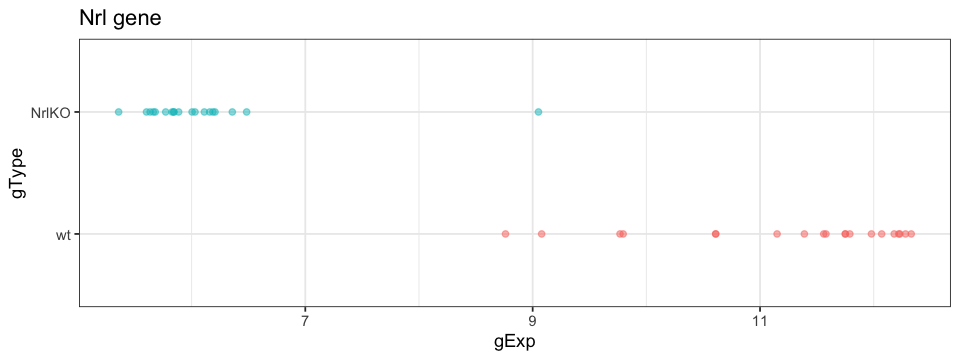

In [9]:
# Filter data for gene
nrlDat <- filter(miniDat, gene == "Nrl")

# Create and display plot of gene expression

(nrlLim <- ggplot(nrlDat, aes(y = gExp, x = gType, colour = gType)) + 
             geom_point(alpha = 0.5) +
             labs(title = "Nrl gene") +
             theme_bw() +
             theme(legend.position = "none") +
             coord_flip())

Notice that the x-axis in both these plots differ quite significantly. If we wish to compare these plots, we should set the plots on a common x-axis.

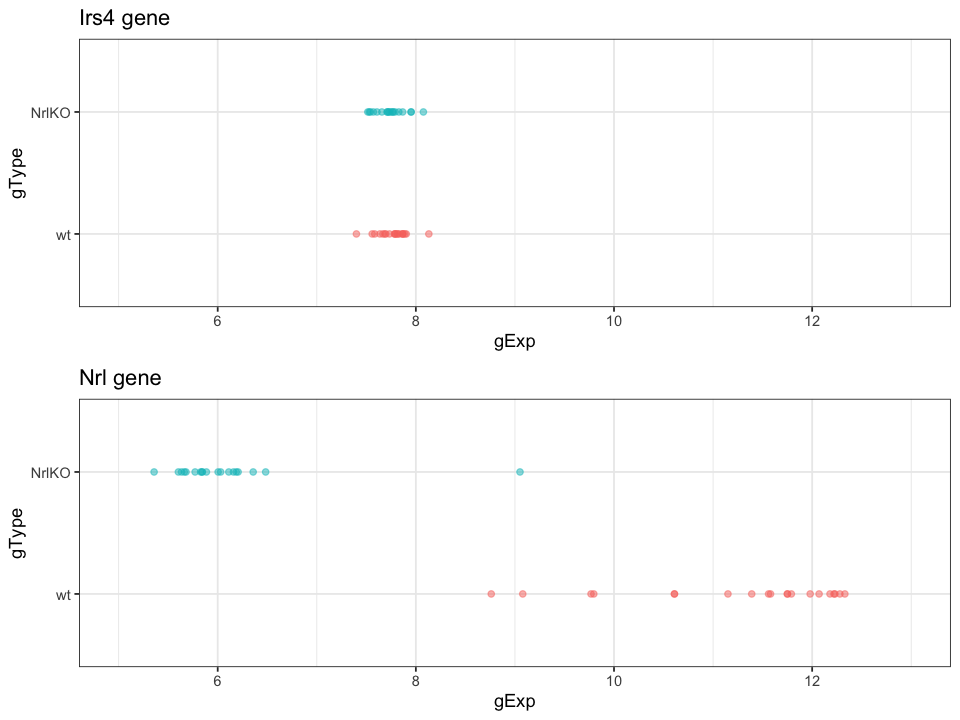

In [10]:
options(repr.plot.width=8, repr.plot.height=6)

grid.arrange(irsLim + ylim(5, 13), nrlLim + ylim(5, 13), ncol = 1)

What is the average gene expression for these genes within each genotype?

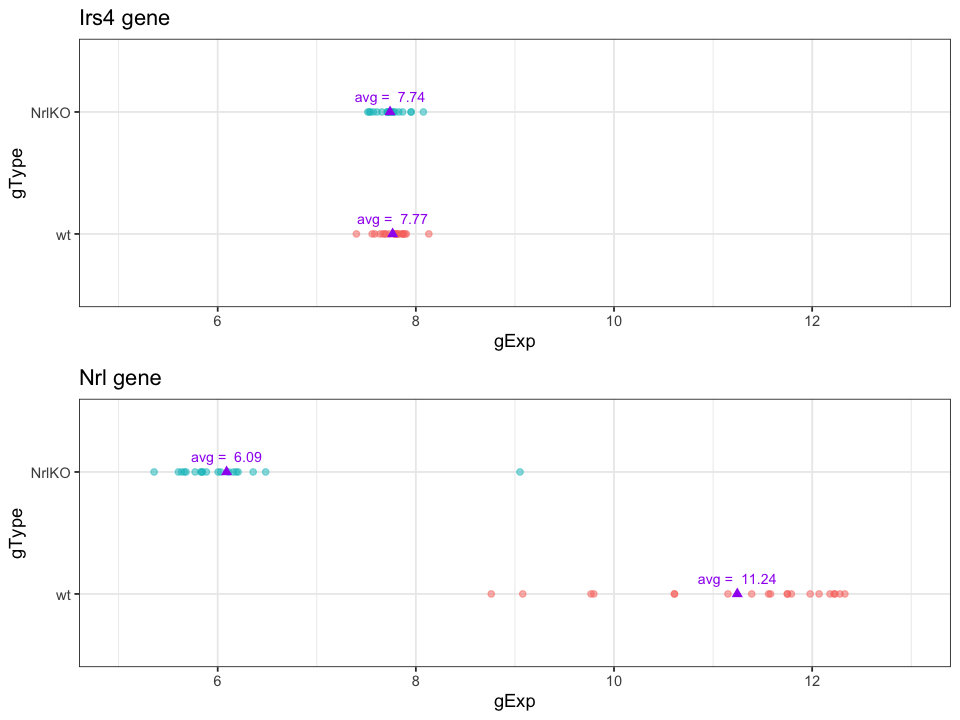

In [11]:
irsMean <- irsLim +
             stat_summary(geom = 'point',
                          fun.y = 'mean',
                          color = 'purple',
                          fill = 'purple',
                          shape = 17,
                          size = 2) +
             stat_summary(aes(label=paste("avg = ",round(..y..,2))), 
                          fun.y = mean, 
                          geom="text",
                          color = 'purple',
                          size=3, 
                          vjust = -1)

nrlMean <- nrlLim +
             stat_summary(geom = 'point',
                          fun.y = 'mean',
                          color = 'purple',
                          fill = 'purple',
                          shape = 17,
                          size = 2) +
             stat_summary(aes(label=paste("avg = ",round(..y..,2))),
                          fun.y = mean, 
                          geom="text",
                          color = 'purple',
                          size=3, 
                          vjust = -1)

# Combine plots together
grid.arrange(irsMean + ylim(5, 13), nrlMean + ylim(5, 13), ncol = 1)

## Density and violin plots
We can also examine the empirical distributions of the gene expression within each genotypic group using density plots or violin plots.

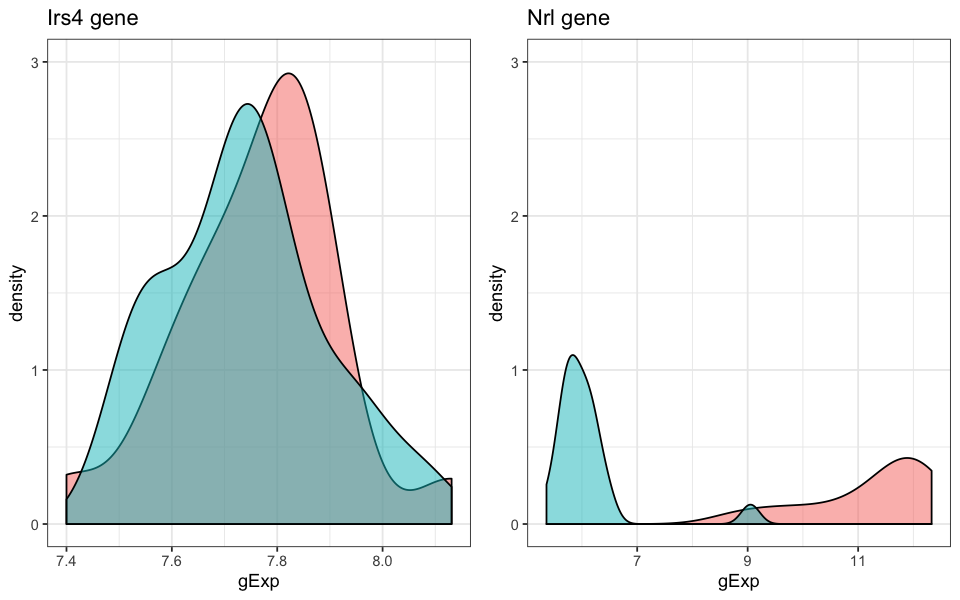

In [12]:
irsDens <- ggplot(irsDat, aes(x = gExp)) + 
             geom_density(aes(fill = gType, alpha = I(0.5))) +
             labs(title = "Irs4 gene") +
             theme_bw() +
             theme(legend.position = "none") + 
             ylim(0, 3)

nrlDens <- ggplot(nrlDat, aes(x = gExp)) + 
             geom_density(aes(fill = gType, alpha = I(0.5))) +
             labs(title = "Nrl gene") +
             theme_bw() +
             theme(legend.position = "none") + 
             ylim(0, 3)

# Combine plots together
options(repr.plot.width=8, repr.plot.height=5)

grid.arrange(irsDens, nrlDens, nrow = 1)

The blue density plot illustrate the empirical distribution of the NrlKO group, whereas the red density plot represents that of the WT group.

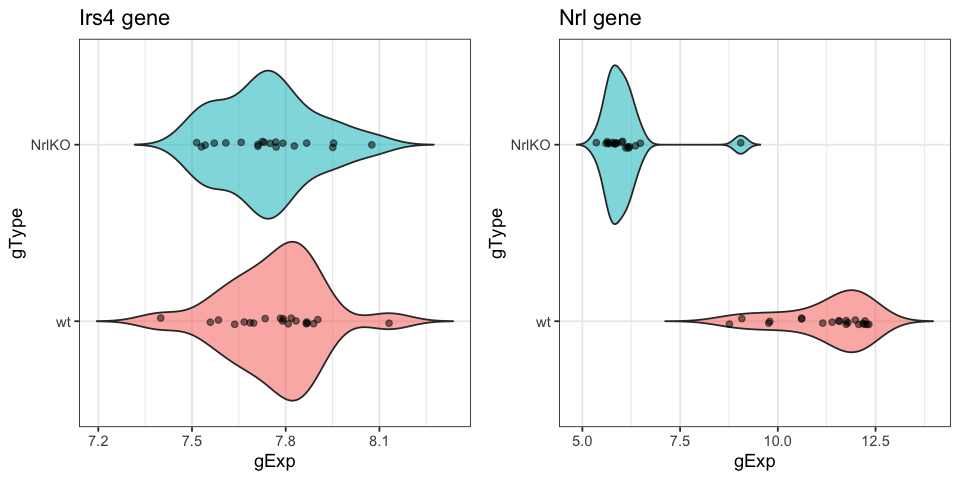

In [13]:
irsViol <- ggplot(irsDat, aes(y = gExp, x = gType)) + 
             geom_violin(trim = FALSE, aes(fill = gType, alpha = 0.5)) +
             geom_jitter(width = 0.02, alpha = 0.5) +
             labs(title = "Irs4 gene") +
             theme_bw() +
             theme(legend.position = "none") +
             coord_flip()

nrlViol <- ggplot(nrlDat, aes(y = gExp, x = gType)) + 
             geom_violin(trim = FALSE, aes(fill = gType, alpha = 0.5)) +
             geom_jitter(width = 0.02, alpha = 0.5) +
             labs(title = "Nrl gene") +
             theme_bw() +
             theme(legend.position = "none") +
             coord_flip()

# Combine plots together
options(repr.plot.width=8, repr.plot.height=4)

grid.arrange(irsViol, nrlViol, nrow = 1)

## Boxplots
Boxplots can be used to visualize the main summary statistics of the data. We can observe the median and IQR of the gene expression within each group, as well as identify any outliers. Note that boxplots can be combined with "violin" plots to have a more complete picture of the empirical distribution.

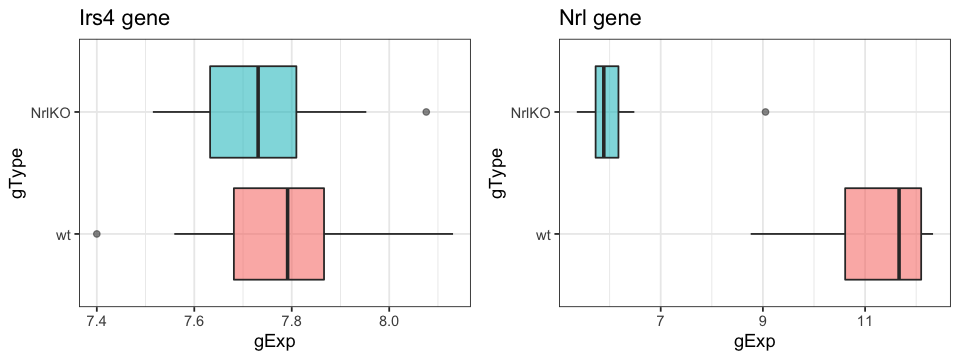

In [14]:
irsBox <- ggplot(irsDat, aes(y = gExp, x = gType)) + 
             geom_boxplot(aes(fill = gType, alpha = 0.5)) +
             labs(title = "Irs4 gene") +
             theme_bw() +
             theme(legend.position = "none") +
             coord_flip()

nrlBox <- ggplot(nrlDat, aes(y = gExp, x = gType)) + 
             geom_boxplot(aes(fill = gType, alpha = 0.5)) +
             labs(title = "Nrl gene") +
             theme_bw() +
             theme(legend.position = "none") +
             coord_flip()

# Combine plots together
options(repr.plot.width=8, repr.plot.height = 3)

grid.arrange(irsBox, nrlBox, nrow = 1)

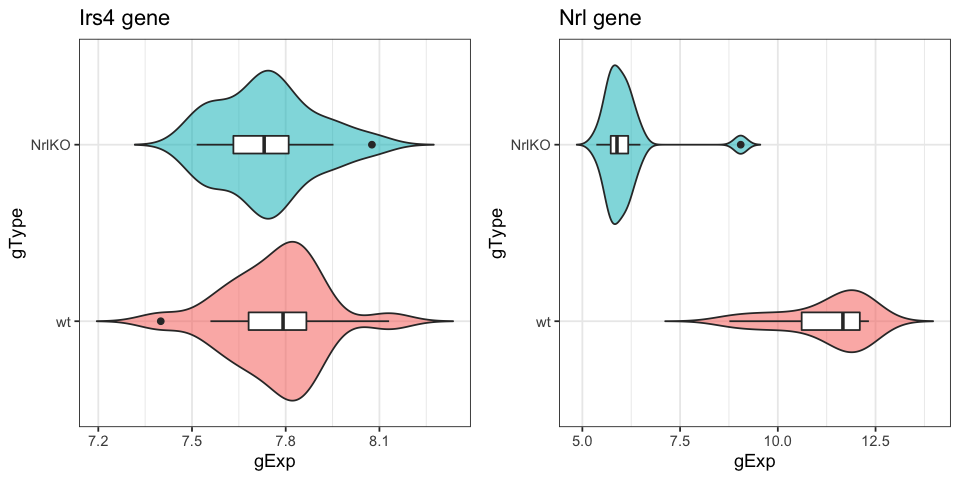

In [15]:
irsViol <- ggplot(irsDat, aes(y = gExp, x = gType)) + 
             geom_violin(trim = FALSE, aes(fill = gType, alpha = 0.5)) +
             geom_boxplot(width=0.1) +
             labs(title = "Irs4 gene") +
             theme_bw() +
             theme(legend.position = "none") +
             coord_flip()

nrlViol <- ggplot(nrlDat, aes(y = gExp, x = gType)) + 
             geom_violin(trim = FALSE, aes(fill = gType, alpha = 0.5)) +
             geom_boxplot(width=0.1) +
             labs(title = "Nrl gene") +
             theme_bw() +
             theme(legend.position = "none") +
             coord_flip()

# Combine plots together
options(repr.plot.width=8, repr.plot.height=4)

grid.arrange(irsViol, nrlViol, nrow = 1)

# Statistical Inference

Now we're interested in testing whether there is a significant difference in gene expression between the wildtype and the NrlKO genotypes. In mathematic notation: 

$$H_0: \mu_Y=\mu_Z \; \; \text{or} \; \; \mu_Y-\mu_Z=0$$

> Recall that our null hypothesis is that there is no difference in the *population* means between the two groups. 

To test this hypothesis let's first examine the sample averages of each genotype and their difference for the two genes of interest. 

### Population *vs* Sample 

It may be confusing to understand the difference between a population parameter and an estimate. In a frequentist paradigm (different in Bayesian), the population parameters are  real numbers, usually unknown, that characterize the whole population. The estimates are numbers computed using our random sample and these change sample to sample. Pay attention to this difference as you keep reading.

## The sample means

In [16]:
## compute the averages of each group
theAvgs <- with(miniDat,
                 tapply(gExp, list(gType, gene), mean))

## round theAvgs to 3 decimal places
round(theAvgs, 3)

## we can also produce these summaries using `dplyr`.
## note that we now get a data frame instead of a numeric matrix

miniDat %>%
    group_by(gType,gene) %>% 
    summarize(mean(gExp))



,Irs4,Nrl
wt,7.766,11.244
NrlKO,7.740,6.090


Warning message:
“The `printer` argument is deprecated as of rlang 0.3.0.
This warning is displayed once per session.”

gType,gene,mean(gExp)
<fct>,<fct>,<dbl>
wt,Irs4,7.765750
wt,Nrl,11.244200
NrlKO,Irs4,7.739684
NrlKO,Nrl,6.089632


Now, we are interested in seeing the difference in averages between WT and NrlKO samples for both Irs4 and Nrl genes.

In [17]:
## take the difference of the averages of "NrlKO" and "WT"
theDiff <- theAvgs["NrlKO", ] - theAvgs["wt", ]

round(theDiff, 3)

Irs4    Nrl 
-0.026 -5.155

## The standard error

To know if these differences are "big enough", we need to properly scale them. Remember that the sample means are random variables and so is their difference. Thus, we can compute the variance of the difference between group sample means, i.e., Var($\bar{Z}_n-\bar{Y}$), to evaluate if the estimated difference of means is far from the true population difference. 

Using some statistical properties and assuming independence and identical distribution, we get:

$$Var(\bar{Z_n}-\bar{Y_n})=Var(\bar{Z_n})+Var(\bar{Y_n})=\frac{\sigma_Z^2}{n_Z}+\frac{\sigma_Y^2}{n_Y}$$

> Notation: $\sigma_Z^2$=Var($Z$).

If we don't know the value of the population variances $\sigma_Z^2$ and $\sigma_Y^2$, then we can estimate them using the *sample* variances. 

### Unequal population variances

Note that you now get an *estimate* of the variance of the sample mean difference, aka the *standard error*. 

$$\hat{Var}(\bar{Z_n}-\bar{Y_n})=\frac{\hat{\sigma}_Z^2}{n_Z}+\frac{\hat{\sigma}_Y^2}{n_Y}=\frac{S_Z^2}{n_Z}+\frac{S_Y^2}{n_Y}$$

> **Notation**: we use hat (^) to distinguish an estimate from a population parameter: e.g., $\hat{\sigma}$ vs $\sigma$. In particular for the sample variance, $S^2$ is usually used isntead of $\hat{\sigma}$. 

So, let's start by computing the sample variances!

In [18]:
## compute the sample variances of each group

theVars <- with(miniDat,
                 tapply(gExp, list(gType, gene), var))

round(theVars, 3)

nY <- with(miniDat, sum(gType == "wt" & gene == "Nrl"))
nZ <- with(miniDat, sum(gType == "NrlKO" & gene == "Nrl"))

,Irs4,Nrl
wt,0.024,1.224
NrlKO,0.023,0.594


For each gene, we can now combine the sample variances using the formula above to estimate the variance of the difference of means:

In [35]:
## assuming unequal true variance

s2DiffWelch <- colSums(theVars / c(nY, nZ))

print("Estimated variance of difference of sample means, assuming unequal population variance:")
round(s2DiffWelch, 3)

[1] "Estimated variance of difference of sample means, assuming unequal population variance:"


Irs4   Nrl 
0.002 0.092

### Equal population variances

If we can assume that the population variances of both groups are equal, i.e., $\sigma_Y^2=\sigma_Z^2=\sigma^2$, then the formula above simplifies to:

$$Var(\bar{Z_n}-\bar{Y_n})=\;\sigma^2\left[\frac{1}{n_Y}+\frac{1}{n_Z}\right]$$

However, note that, in general, we still don't know the value of $\sigma^2$ so we still need to estimate it. 

To estimate the "common" variance of each population, we can combine the sample variances obtained from each sample. This combined sample variance is known as the "pooled" variance:

$$'pooled'\;\hat{\sigma}^2=S_Y^2\frac{n_Y-1}{n_Y+n_Z-2}+S_Z^2\frac{n_z-1}{n_Y+n_Z-2}$$

This estimate can now be use as the standard error of the difference in means (i.e., to *estimate* the variance of the difference of sample means):

$$\hat{V}(\bar{Z_n}-\bar{Y_n})=\;'pooled'\;\hat{\sigma}^2\left[\frac{1}{n_Y}+\frac{1}{n_Z}\right]$$

In [36]:
## assuming equal true variance

print("Calculating the estimated pooled sample variance")
s2Pooled <- colSums(theVars * c((nY - 1) / (nY + nZ - 2),
                                 (nZ - 1) / (nY + nZ - 2)))
round(s2Pooled, 3)

print("Estimated variance of difference of sample means, assuming equal population variance:")
s2Diff <- s2Pooled * (1/nY + 1/nZ)
round(s2Diff, 3)

[1] "Calculating the estimated pooled sample variance"


Irs4   Nrl 
0.024 0.918

[1] "Estimated variance of difference of sample means, assuming equal population variance:"


Irs4   Nrl 
0.002 0.094

## The *t*-test

With the **difference in sample means** and our **estimate of the variance** of the difference between group sample means, we can compute the **test statistic** to test the null statistical hypothesis:

> $$H_0: \mu_Y=\mu_Z \; \; \text{or} \; \; \mu_Y-\mu_Z=0$$

If we assume unequal group variances, the statistical test is called the **Welch two-sample *t*-test**, and their results for both Irs4 and Nrl are shown below. 

In [21]:
print("Calculating the Welch test-statistic for each gene")
welchStat <- theDiff / sqrt(s2DiffWelch)
round(welchStat, 3)

[1] "Calculating the Welch test-statistic for each gene"


Irs4     Nrl 
 -0.529 -16.949

**What does this mean?** The difference in sample means is about half a standard error for Irs4 and ~16 standard errors for Nrl. As expected, there is a big difference for Nrl gene, not so much for Irs4. 

In R, we can perform the Welch two-sample *t*-test using the `t.test` function. This functions gives us an estimate of each sample mean as well as a p-value for the test statistic based on its [null sampling distribution](#The-Null-Distribution). 

In [38]:
by(miniDat, miniDat$gene, function(theDat) {
  theDat$gType <- factor(theDat$gType, rev(levels(theDat$gType)))
  t.test(gExp ~ gType, theDat)
})

miniDat$gene: Irs4

	Welch Two Sample t-test

data:  gExp by gType
t = -0.52886, df = 36.948, p-value = 0.6001
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1259351  0.0738035
sample estimates:
mean in group NrlKO    mean in group wt 
           7.739684            7.765750 

------------------------------------------------------------ 
miniDat$gene: Nrl

	Welch Two Sample t-test

data:  gExp by gType
t = -16.949, df = 34.005, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -5.772630 -4.536507
sample estimates:
mean in group NrlKO    mean in group wt 
           6.089632           11.244200 


Notably, the tests corresponding to the Irs4 gene and Nrl gene have p-values of 0.6001 and nearly 0, respectively. This suggests a statistically significant difference in mean gene expression for Nrl, but not for Irs4.

Let us perform the same tests, but this time assuming that the **group variances are equal**. The results are very similar. The test we choose to perform will depend on which assumption we want to make about the population distributions.

In [37]:
print("Calculating the test statistic for each gene assuming equal population variances")
tstStat <- theDiff / sqrt(s2Diff)

round(tstStat, 3)

[1] "Calculating the test statistic for each gene assuming equal population variances"


Irs4     Nrl 
 -0.529 -16.795

Again, we can use the `t.test` function in R to perform this test. 

In [24]:
by(miniDat, miniDat$gene, function(theDat) {
  theDat$gType <- factor(theDat$gType, rev(levels(theDat$gType)))
  t.test(gExp ~ gType, theDat, var.equal = TRUE)
})

miniDat$gene: Irs4

	Two Sample t-test

data:  gExp by gType
t = -0.52865, df = 37, p-value = 0.6002
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.12597002  0.07383844
sample estimates:
mean in group NrlKO    mean in group wt 
           7.739684            7.765750 

------------------------------------------------------------ 
miniDat$gene: Nrl

	Two Sample t-test

data:  gExp by gType
t = -16.795, df = 37, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -5.776439 -4.532698
sample estimates:
mean in group NrlKO    mean in group wt 
           6.089632           11.244200 


Notice that the p-value is 0.6002 for Irs4 gene and 2.2e-16 for Nrl.

## The null distribution
The null distribution is the distribution of the test statistic (aka the sampling distribution) under the null hypothesis. In our case, it is the sampling distribution of *t* assuming that the population means are equal ($\mu_Y=\mu_Z$).

If we assume that the true distributions of $Y$ and $Z$ are Normal, theoretically, we prove that the distribution of *t* is a central Student's t-distribution.

> if the population variances are known, then the distribution of *t* is also Normal.

> if the variances are *estimated* using the sample variances, then the distribution becomes a Student's t-distribution.

If we can't or don't want to assume normality but the sample size is large, using the Central Limit Theorem (CLT) we can prove that the null sampling distribution is *asymptotically* Normal (if variances are known) or Student's t (if variances are estimated). 

Depending on the assumptions made, the null sampling distribution in our example is (exactly or asymptotically) $N(0,1)$ or central Student's t.

> note that the mean of the Normal distribution is 0 because under the null hypothesis the difference of means is 0. Also the SD is 1 because the difference is scaled with the SE. Similarly, under the null hypothesis, centrality parameter of the Student's t is 0 and the degrees of freedom are $n-2=37$ because we estimated 2 parameters (the mean and the variance) 

Below we illustrate the Student's t-distribution (red dotted line) with 37 degrees of freedom and the Normal distribution (black line). 

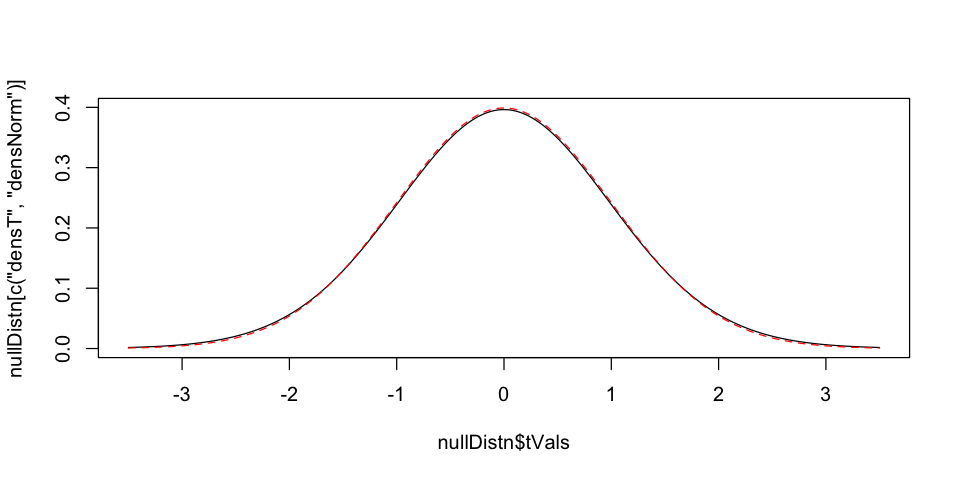

In [25]:
## draw the null dist'n

nullDistn <- data.frame(tVals = seq(-3.5, 3.5, length = 300))
nullDistn$densT <- dt(nullDistn$tVals, df = nY + nZ - 2)
nullDistn$densNorm <- dnorm(nullDistn$tVals)

with(nullDistn,
     matplot(x = nullDistn$tVals,
             y = nullDistn[c("densT", "densNorm")],
             type = "l"))

Now we examine where the test statistic for Irs4 lies on the sampling distribution. The highlighted areas in blue is a visualization of our p-value, our measure of how likely we are to see a test statistic as or more extreme than what we observed assuming that the null hypothesis is true.

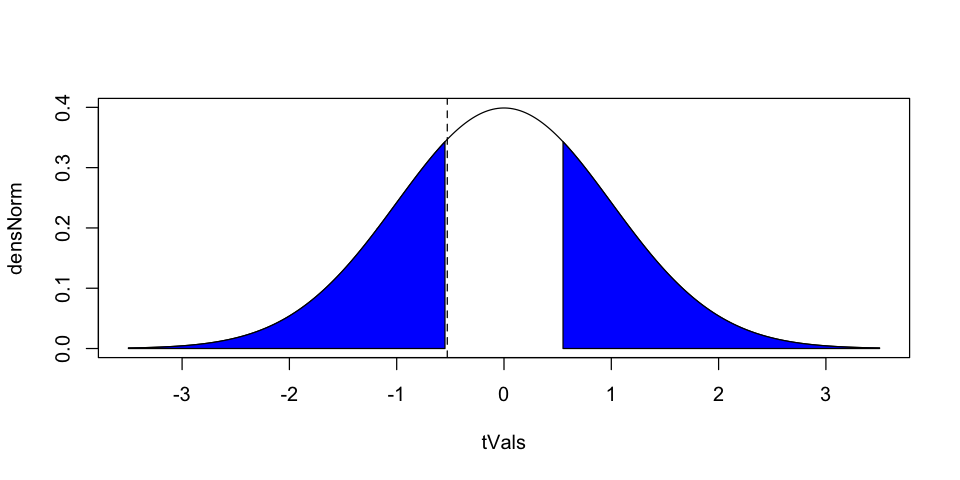

In [41]:
## depicting only for Irs4!

with(nullDistn,
     plot(densNorm ~ tVals, type = "l"))
abline(v = tstStat["Irs4"], lty = "dashed")

foo <- subset(nullDistn, tVals < tstStat["Irs4"])
polygon(x = c(foo$tVals, rev(foo$tVals)),
        y = c(rep(0, nrow(foo)), rev(foo$densNorm)),
        col = "blue")

polygon(x = -1 * c(foo$tVals, rev(foo$tVals)),
        y = c(rep(0, nrow(foo)), rev(foo$densNorm)),
        col = "blue")

We can see that the probability of seeing a test statistic as extreme as that observed (*t* = -0.53) is pretty high. And thus, for Irs4, we do not have enough evidence to reject the null hypothesis!

In [42]:
paste("Irs4 test statistic: ", round(tstStat["Irs4"],3))

print("Probability of observation assuming equal population variances")
round(pt(-1 * abs(tstStat), df = nY + nZ - 2) * 2, 3)

print("Probability of observation assuming unequal population variances")
round(pnorm(-1 * abs(tstStat)) * 2, 3)

[1] "Irs4 test statistic:  -0.529"

[1] "Probability of observation assuming equal population variances"


Irs4  Nrl 
 0.6  0.0

[1] "Probability of observation assuming unequal population variances"


Irs4   Nrl 
0.597 0.000

# Wilcoxon Rank Sum Test
The Wilcoxon Rank Test can also be used to test the null hypothesis that the means gene expression between two groups are equal. This is a non-parametric test and it doesn't make any assumptions about the distribution or parameters of the populations.

In [27]:
(wilcTest <- by(miniDat, miniDat$gene, function(theDat) {
    wilcox.test(gExp ~ gType, theDat)
}))

Warning message in wilcox.test.default(x = c(7.867, 7.783, 7.585, 7.4, 7.667, 7.818, :
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x = c(8.761, 9.079, 10.61, 9.796, 11.39, :
“cannot compute exact p-value with ties”

miniDat$gene: Irs4

	Wilcoxon rank sum test with continuity correction

data:  gExp by gType
W = 220.5, p-value = 0.3992
alternative hypothesis: true location shift is not equal to 0

------------------------------------------------------------ 
miniDat$gene: Nrl

	Wilcoxon rank sum test with continuity correction

data:  gExp by gType
W = 379, p-value = 1.178e-07
alternative hypothesis: true location shift is not equal to 0


The warning messages tell us that there is a tie within the gene expression values of the dataset. 

Notice that the test statistic is 220.5 for Irs4 and 379 for Nrl. 

### By hand...
Can we confirm these findings of the test by computing the rank sum test-statistic by hand?

In [28]:
# Calculate ranks of the gene expressions for Irs4 and Nrl
by(miniDat, miniDat$gene, function(theDat) rank(theDat$gExp))

miniDat$gene: Irs4
 [1] 31.5 22.0  7.0  1.0 38.0  2.0 37.0 11.0 27.0 35.0 13.0 28.0 36.0 16.0 24.0
[16] 39.0 12.0 18.0 34.0 10.0  8.0  3.0  4.0 29.0  9.0 23.0 30.0 21.0 19.0 31.5
[31] 14.5 33.0 25.0  5.0 26.0 17.0 14.5  6.0 20.0
------------------------------------------------------------ 
miniDat$gene: Nrl
 [1] 19.0 21.0 24.5 23.0 15.0  9.0  1.0 27.0 24.5 28.0 22.0  8.0  5.0 14.0 17.0
[16] 26.0 34.0 29.0 30.5 16.0 12.0 13.0 18.0 35.0 33.0 30.5 32.0 10.0  7.0  3.0
[31] 11.0 37.0 38.0 39.0 36.0  2.0  4.0  6.0 20.0

As you can see, some of the ranks here are ending with .5, implying that there are ties in the dataset. 

In [29]:
## let's recreate the Wilcoxon test statistic
(jRankSums <- by(miniDat, miniDat$gene, function(theDat) {
    tapply(rank(theDat$gExp), theDat$gType, sum)
}))

miniDat$gene: Irs4
   wt NrlKO 
430.5 349.5 
------------------------------------------------------------ 
miniDat$gene: Nrl
   wt NrlKO 
  589   191 

In [30]:
sampSize <- c(nY, nZ)
sapply(jRankSums, function(foo) foo - sampSize * (sampSize + 1)/2)

,Irs4,Nrl
wt,220.5,379
NrlKO,159.5,1


Let us compare our output to that of the "official" test earlier.

Focus on the first row of that table -- the rank sums for wild type with the associated minimum subtracted.

In [31]:
sapply(wilcTest, function(foo) foo$stat)

Irs4.W  Nrl.W 
 220.5  379.0

**Notice that they are the same!** We've computed the test statistic for ourselves.

# Kolmogorov-Smirnov Test (two sample)

The Kolmogorov-Smirnov Test is another non-parametric method. However, this test is used to test statistical significance. This method uses the empirical CDF for estimation to draw conclusions about the true CDF. The test statistic here is represented by the absolute difference between the empircal CDF of two samples.

In [32]:
(ksTest <- by(miniDat, miniDat$gene, function(theDat) {
    ks.test(x = theDat$gExp[theDat$gType == "wt"],
            y = theDat$gExp[theDat$gType == "NrlKO"])
}))

Warning message in ks.test(x = theDat$gExp[theDat$gType == "wt"], y = theDat$gExp[theDat$gType == :
“cannot compute exact p-value with ties”Warning message in ks.test(x = theDat$gExp[theDat$gType == "wt"], y = theDat$gExp[theDat$gType == :
“cannot compute exact p-value with ties”

miniDat$gene: Irs4

	Two-sample Kolmogorov-Smirnov test

data:  theDat$gExp[theDat$gType == "wt"] and theDat$gExp[theDat$gType == "NrlKO"]
D = 0.28421, p-value = 0.4107
alternative hypothesis: two-sided

------------------------------------------------------------ 
miniDat$gene: Nrl

	Two-sample Kolmogorov-Smirnov test

data:  theDat$gExp[theDat$gType == "wt"] and theDat$gExp[theDat$gType == "NrlKO"]
D = 0.95, p-value = 4.603e-08
alternative hypothesis: two-sided


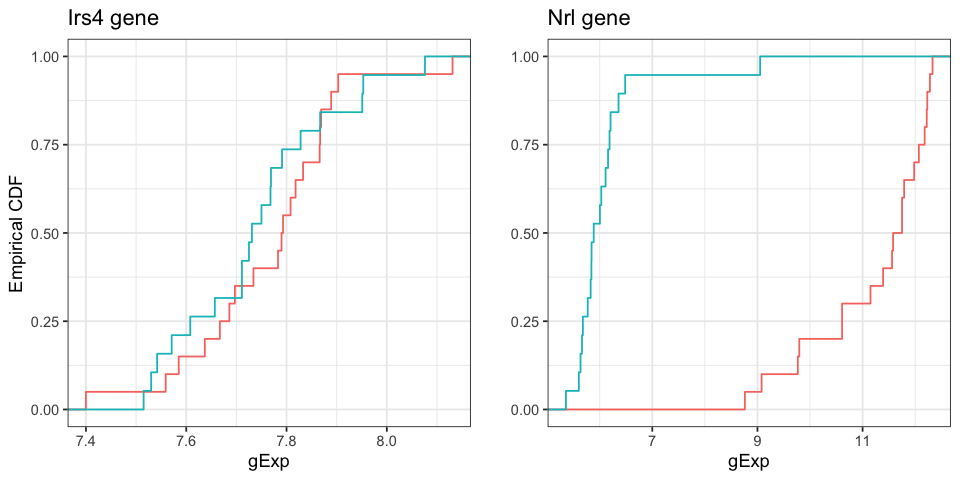

In [33]:
irsecdf <- ggplot(irsDat, aes(gExp, colour=gType)) +
    stat_ecdf(geom = "step") +
    theme_bw() +
    theme(legend.position = "none") +
    labs(title = "Irs4 gene") +
    ylab("Empirical CDF")

nrlecdf <- ggplot(nrlDat, aes(gExp, colour=gType)) +
    stat_ecdf(geom = "step") +
    theme_bw() +
    theme(legend.position = "none") +
    labs(title = "Nrl gene") +
    ylab("")


# Combine plots together
options(repr.plot.width=8, repr.plot.height=4)

grid.arrange(irsecdf, nrlecdf, nrow = 1)